In [195]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler,RobustScaler,StandardScaler

In [196]:
def links(link):
    l = []
    for ind, i in enumerate(link):
        dist = i[2]
        col = i[3]
        l.append([ind,dist,col])
    return l

def plot_links(link):
    l = links(link)
    d = pd.DataFrame(l,columns=['step','distance','volume'])
    f, ax = plt.subplots(figsize=(10, 10))
    sns.scatterplot(x="step", y="distance",
                    size="volume",data=d,
                    hue="volume",
                    palette="Spectral")
    
def plot_model(df,cluster):
    f, ax = plt.subplots(figsize=(10, 10))
    sns.scatterplot(x = 'x',y = 'y',data = df,hue=df[cluster],palette="Spectral")

In [197]:
f = open('clusters_main.txt')
rows = []
for row in f:
    row = row.split()
    rows.append(map(float,row))
rows = rows[1:]

In [198]:
df = pd.DataFrame(rows,columns=['x','y'])

In [199]:
df

,x,y
0,68.601997,102.491997
1,454.665985,264.808990
2,101.283997,169.285995
3,372.614990,263.140991
4,300.989014,46.555000
...,...,...
7995,442.420990,303.721985
7996,495.451996,288.502991
7997,267.605011,141.725006
7998,238.358002,252.729996


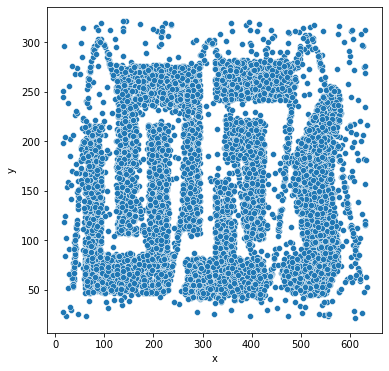

In [200]:
f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(x = 'x',y = 'y',data = df)
# отчетливо видны отдельные кластеры
# конечное задание - определить оптимальный алгоритм для этого набора данных

In [201]:
# нармализуем

F:\Anaconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


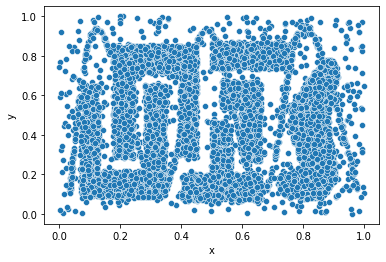

In [202]:
df_mmscaled = MinMaxScaler().fit(df).transform(df)
df_mmscaled = pd.DataFrame(df_mmscaled,columns=['x','y'])
sns.scatterplot('x','y',data = df_mmscaled)

F:\Anaconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


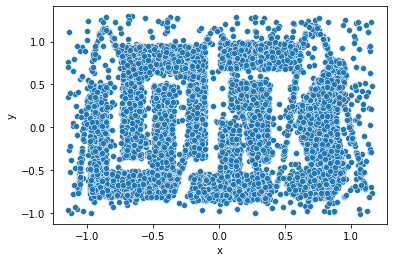

In [203]:
df_rscaled = RobustScaler().fit(df).transform(df)
df_rscaled = pd.DataFrame(df_rscaled,columns=['x','y'])
sns.scatterplot('x','y',data = df_rscaled)

F:\Anaconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


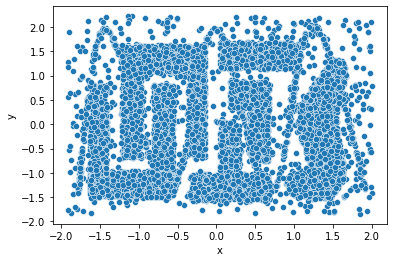

In [204]:
df_sscaled = StandardScaler().fit(df).transform(df)
df_sscaled = pd.DataFrame(df_sscaled,columns=['x','y'])
sns.scatterplot('x','y',data = df_sscaled)

In [205]:
# как видно нормализация в данном наборе не сильно полезна, лишь меняет масштаб,
# некоторые алгоритмы чувствительны к масштабированию, например SVM(support vector machine)
# поэтому нормализацию в данном случае можно не делать если не использовать подобные алгоритмы, 
# но пусть все же будет...StandardScaler (средняя 0, дисперсия 1)

# очеваидно, что на графике есть кластеры (6) и шум в виде отдельных точек и синусоиды
# построим дендограмму 

F:\Anaconda\lib\site-packages\seaborn\matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


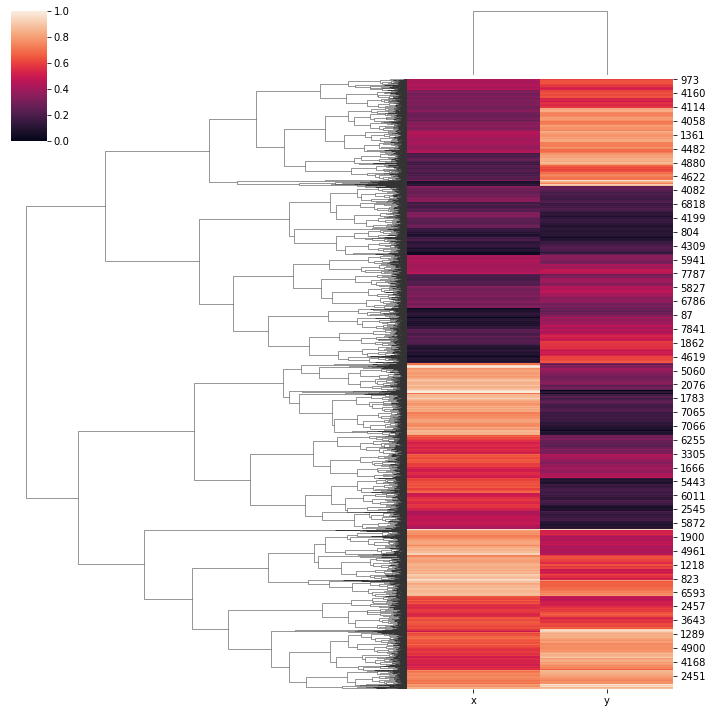

In [206]:
# 9 кластеров для MinMaxScaler
minmax = sns.clustermap(df_mmscaled,dendrogram_ratio=(.6, .1))

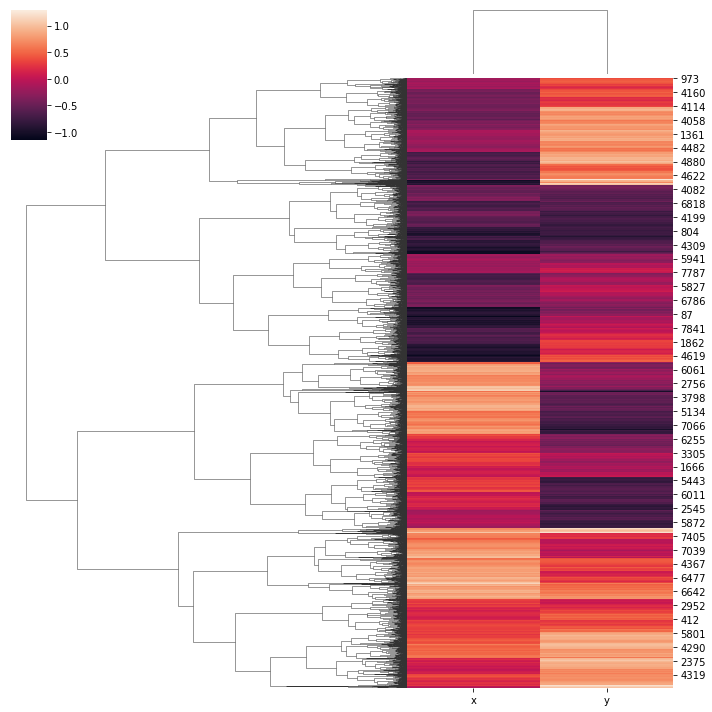

In [207]:
# 9 кластеров для RobustScaler
cluster = sns.clustermap(df_rscaled,dendrogram_ratio=(.6, .1))

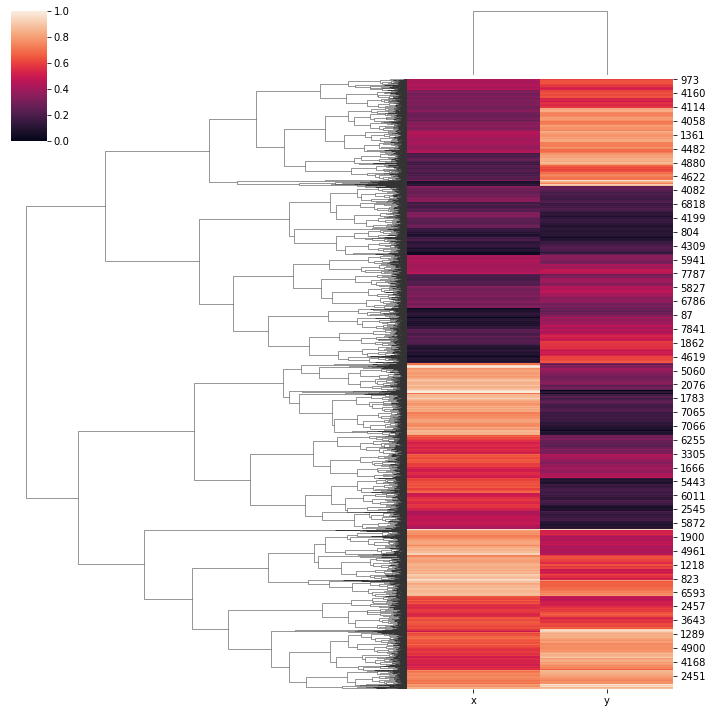

In [208]:
standard = sns.clustermap(df_sscaled,standard_scale=1,dendrogram_ratio=(.6, .1))
# 9 кластеров для StandatdScaler

In [209]:
# 8-9 кластеров 
#plot_links(minmax.dendrogram_row.calculated_linkage)

In [210]:
# Алгоритмы : k-mean, Agglomerative clustering (ward/average/complete), DBSCAN
# Нормализация : MinMaxScaler()
df_test = df_mmscaled.copy()


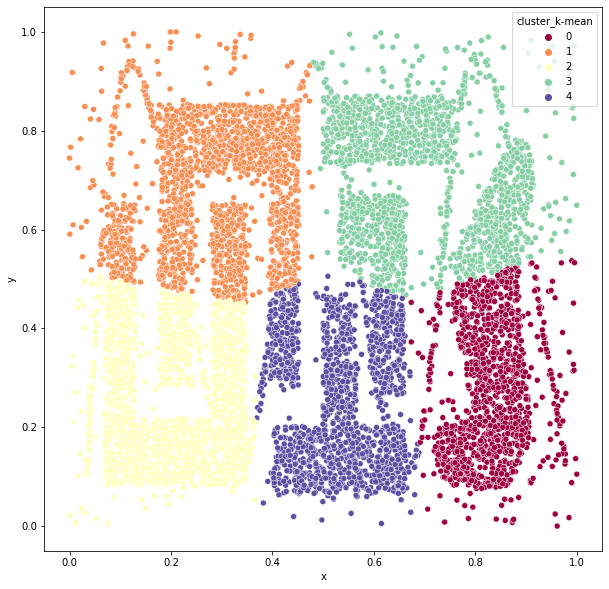

In [211]:
# k-mean 
from sklearn.cluster import KMeans
model = KMeans(n_clusters=5,random_state=101).fit_predict(df_test)
df_mmscaled['cluster_k-mean'] = model
plot_model(df_mmscaled,'cluster_k-mean')
# видно, что k-mean кластеризировал точки на 6 груп, но очевидно не правильно.
# Основная проблема в том что данный алгоритм плохо работает с данными, которые
# выражены сложными формами, как в данном случае.
# Алгоритм подразумевает наличие центроидов, то есть ближайшие точки к
# центроиду получат тот же класс, что и центроид (инициализируется случайно).
# Можно сказать, что кластеры имеют одинаковый диаметр, но граница между
# кластерами проходит точно посередине между центрами кластеров. Поэтому
# учитывать только растояние от центра кластера для данного набора не разумно.


'\nСитуация не сильно улучшилась, если вообще улучшилась. Алгоритм на 1 шаге\nприсваивает каждой точке свой кластер, а затем объединяет наиболее похожие кластеры.\nПока не будет достигнут критерий остановки в виде нужного кол-ва кластеров.\nСхожесть кластеров оценивается на основе нескольких критериев связи:\n    ward(default) - объединяет так, чтобы прирост дисперсии был минимальным\n    average - объединяет 2 кластера, которые имеют наименьшее среднее значение всех расстояний между точками кластеров\n    complete - бъединяет 2 кластера,которые имеют наименьшее расстояние между двумя их самыми удаленными точками\n'

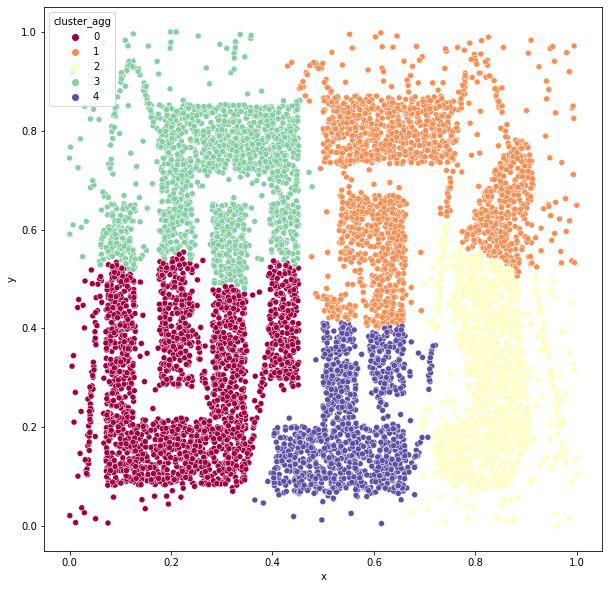

In [212]:
# Agglomerative clustering
'''
Иерархический алгоритм. Он используется для группировки объектов в кластеры 
на основе того, насколько они похожи друг на друга. 
Это форма восходящей кластеризации, где каждая точка данных назначается своему
собственному кластеру. Затем эти кластеры соединяются вместе.
'''
from sklearn.cluster import AgglomerativeClustering
model = AgglomerativeClustering(n_clusters=5,linkage='ward').fit_predict(df_test)
df_mmscaled['cluster_agg'] = model
plot_model(df_mmscaled,'cluster_agg')
'''
Ситуация не сильно улучшилась, если вообще улучшилась. Алгоритм на 1 шаге
присваивает каждой точке свой кластер, а затем объединяет наиболее похожие кластеры.
Пока не будет достигнут критерий остановки в виде нужного кол-ва кластеров.
Схожесть кластеров оценивается на основе нескольких критериев связи:
    ward(default) - объединяет так, чтобы прирост дисперсии был минимальным
    average - объединяет 2 кластера, которые имеют наименьшее среднее значение всех расстояний между точками кластеров
    complete - бъединяет 2 кластера,которые имеют наименьшее расстояние между двумя их самыми удаленными точками
'''

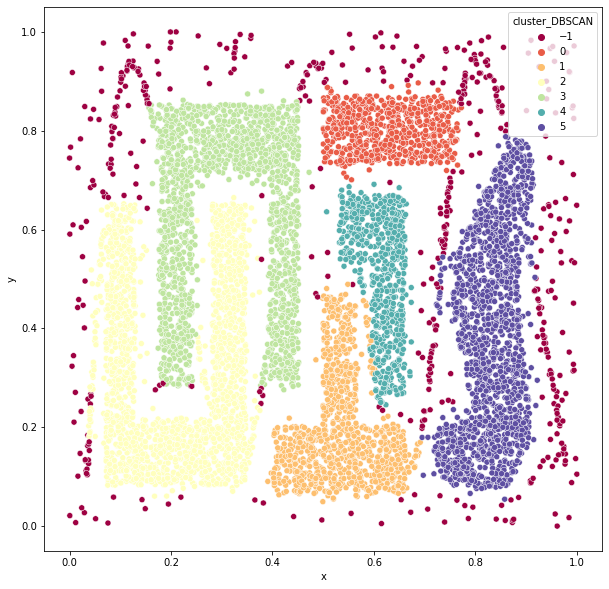

In [213]:
# DBSCAN 0.355 49
# Алгоритм основанный на плотностном распределении нашел все 6 кластеров
# Минус алгоритма в том, что долго приходится подгонять коэффициенты
from sklearn.cluster import DBSCAN
model = DBSCAN(eps=0.0356,min_samples=49).fit_predict(df_test)
df_mmscaled['cluster_DBSCAN'] = model
plot_model(df_mmscaled,'cluster_DBSCAN')

In [214]:
df_mmscaled

,x,y,cluster_k-mean,cluster_agg,cluster_DBSCAN
0,0.086988,0.270828,2,0,2
1,0.709356,0.812800,3,1,0
2,0.139674,0.493851,1,0,2
3,0.577083,0.807231,3,1,0
4,0.461616,0.084055,4,4,1
...,...,...,...,...,...
7995,0.689616,0.942730,3,1,-1
7996,0.775106,0.891914,3,1,-1
7997,0.407798,0.401826,4,0,3
7998,0.360649,0.772469,1,3,3


In [215]:
# чистим
cleared_df = df_mmscaled.loc[:,:'y']
cleared_df['marks'] = df_mmscaled['cluster_DBSCAN'] 

In [216]:
cleared_df = cleared_df[cleared_df['marks'] != -1]

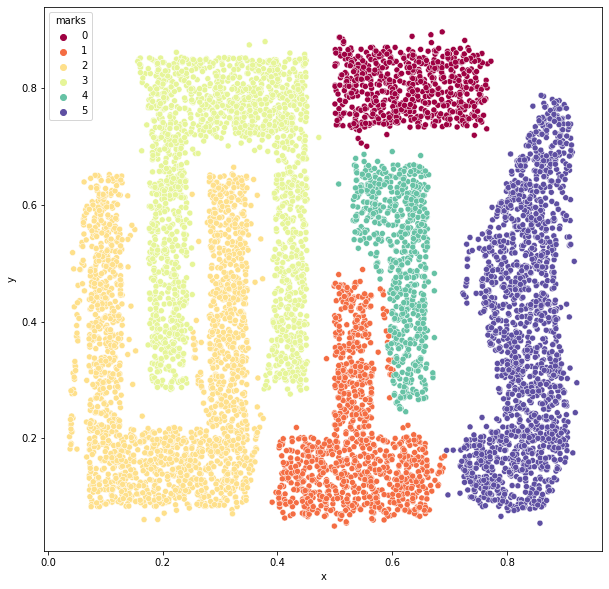

In [217]:
plot_model(cleared_df,'marks')

F:\Anaconda\lib\site-packages\seaborn\matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


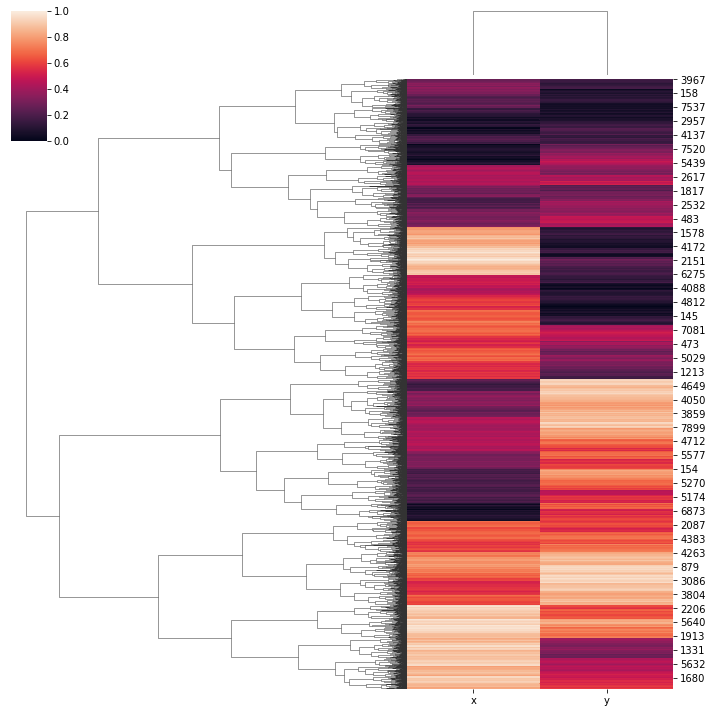

In [218]:
standard = sns.clustermap(cleared_df.iloc[:,:-1],standard_scale=1,dendrogram_ratio=(.6, .1))

In [219]:
# 1-ая часть 5 лабораторной работы

In [220]:
# в итоге получился такой набор:
df_mmscaled.drop(['cluster_k-mean','cluster_agg'],axis=1) # неотчищенный набор (,inplace=True)
cleared_df.reset_index(drop=True) # отчищенный набор, делее работаем с ним. Если нужно - поменять на неотчищенный

,x,y,marks
0,0.086988,0.270828,2
1,0.709356,0.812800,0
2,0.139674,0.493851,2
3,0.577083,0.807231,0
4,0.461616,0.084055,1
...,...,...,...
7482,0.826707,0.146210,5
7483,0.571906,0.863863,0
7484,0.407798,0.401826,3
7485,0.360649,0.772469,3


In [221]:
from sklearn.model_selection import train_test_split 
y = cleared_df['marks']
X = cleared_df.iloc[:,:].drop('marks',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [222]:
y_train = cleared_df.loc[0:6000,'marks']
X_train = cleared_df.loc[0:6000,:].drop('marks',axis=1)

y_test = cleared_df.loc[6000:,'marks']
X_test = cleared_df.loc[6000:,:].drop('marks',axis=1)

In [223]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=5).fit(X_train,y_train)


In [224]:
predicted_classes = model.predict(X_test)

In [225]:
# общий результат классификации R^2
model.score(X_test,y_test)

0.997289972899729

In [226]:
train_data = X_train
train_data['class'] = y_train
train_data['type'] = ['Train' for x in range(len(X_train))]
train_data

,x,y,class,type
0,0.086988,0.270828,2,Train
1,0.709356,0.812800,0,Train
2,0.139674,0.493851,2,Train
3,0.577083,0.807231,0,Train
4,0.461616,0.084055,1,Train
...,...,...,...,...
5996,0.317859,0.434381,2,Train
5997,0.110566,0.446181,2,Train
5998,0.656504,0.564714,4,Train
5999,0.867933,0.493224,5,Train


In [227]:
test_data = X_test
test_data['class'] = predicted_classes
test_data['type'] = ['Test' for x in range(len(X_test))]

test_data

,x,y,class,type
6000,0.283843,0.554584,2,Test
6001,0.136179,0.083541,2,Test
6002,0.832893,0.421820,5,Test
6003,0.730934,0.494729,5,Test
6004,0.777708,0.423920,5,Test
...,...,...,...,...
7993,0.826707,0.146210,5,Test
7994,0.571906,0.863863,0,Test
7997,0.407798,0.401826,3,Test
7998,0.360649,0.772469,3,Test


In [228]:
comb = train_data.append(test_data)

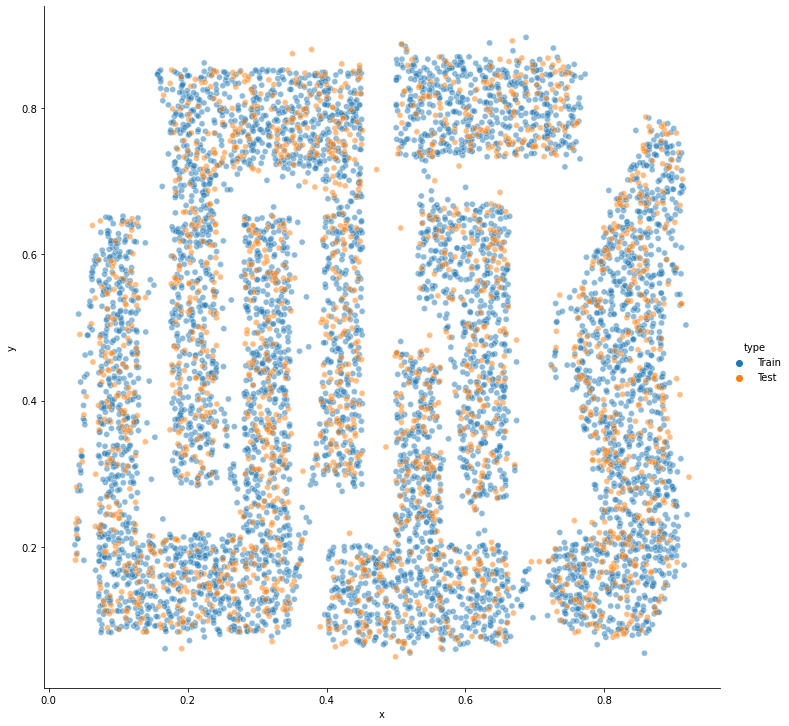

In [229]:
# Обучающие и тестовые точки
sns.relplot(x="x", y="y", hue="type",
            sizes=(20, 90), alpha=.5,
            height=10, data=comb)

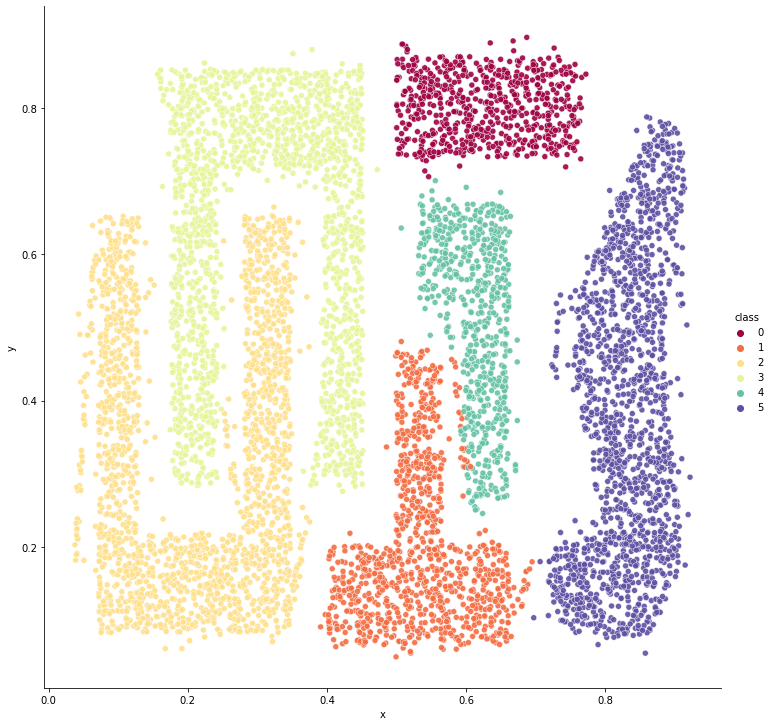

In [230]:
# Классы точек
sns.relplot(x="x", y="y", hue="class",
            sizes=(20, 90), alpha=.9, palette="Spectral",
            height=10, data=comb)